In [16]:
local_path = !pwd

In [17]:
video_path = local_path[0] + '/video/'
video_path_jpg = local_path[0] + '/video_jpg/'

In [19]:
!python utils/video_jpg.py $video_path $video_path_jpg

ffmpeg -i /home/qq/CSCE689/3D-ResNets-PyTorch/video/8test1.mp4 -vf scale=-1:360 /home/qq/CSCE689/3D-ResNets-PyTorch/video_jpg/8test1/image_%05d.jpg
ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enab

In [20]:
!python utils/n_frames.py $video_path_jpg

/home/qq/CSCE689/3D-ResNets-PyTorch/video_jpg/8test 4213
/home/qq/CSCE689/3D-ResNets-PyTorch/video_jpg/8test1 4213
/home/qq/CSCE689/3D-ResNets-PyTorch/video_jpg/8test 4213
/home/qq/CSCE689/3D-ResNets-PyTorch/video_jpg/8test1 4213
/home/qq/CSCE689/3D-ResNets-PyTorch/video_jpg/8test 4213
/home/qq/CSCE689/3D-ResNets-PyTorch/video_jpg/8test1 4213


In [46]:
import os
import sys
import json
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

from opts import parse_opts
from mean import get_mean, get_std
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
import collections
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from joblib import dump, load
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import accuracy_score

from models import *

In [47]:
import easydict
opt = easydict.EasyDict({
    "result_path": 'results2',
    "dataset": 'ucf101-music', # 'ucf101',
    "n_classes": 2, 
    "sample_size": 112,
    "sample_duration": 64,
    "initial_scale": 1.0,
    "n_scales": 5,
    "scale_step": 0.84089641525,
    "train_crop": 'corner',
    "learning_rate": 0.1,
    "momentum": 0.9,
    "dampening": 0.9,
    "weight_decay": 0.001,
    "mean_dataset": 'kinetics',
    "no_mean_norm": False,
    "std_norm": False,
    "nesterov": False,
    "optimizer": 'sgd',
    "lr_patience": 10,
    "batch_size": 16,
    "n_epochs": 2,
    "begin_epoch": 1,
    "n_val_samples": 3,
    "ft_begin_index": 5,
    "scale_in_test": 1.0,
    "crop_position_in_test": 'c',
    "no_softmax_in_test": False,
    "no_cuda": False,
    "n_threads": 4,
    "checkpoint": 2,
    "no_hflip": False,
    "norm_value": 1,
    "model": 'resnet',
    "pretained_model_name": 'resnext-101-kinetics',
    "model_depth": 101,
    "resnet_shortcut": 'B',
    "wide_resnet_k": 2,
    "resnext_cardinality": 32,
    "manual_seed": 1,
    'test_subset': 'test',
})
opt.arch = '{}-{}'.format(opt.model, opt.model_depth)
opt.root_path =  local_path[0]
opt.video_path = video_path_jpg
# opt.annotation_path = opt.root_path + 'video/UCF-music-annotation/ucf_binary_music_annotation.json'

In [48]:
# use two gpu devices on the server, you can customize it depending on how many available gpu devices you have
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [49]:
from datasets.no_label_binary import NoLabelBinary

mean = get_mean(opt.norm_value, dataset='kinetics')
std = get_std(opt.norm_value)
norm_method = Normalize(mean, [1,1,1])


spatial_transform = Compose([
    Scale(opt.sample_size),
    CornerCrop(opt.sample_size, 'c'),
    ToTensor(opt.norm_value), norm_method
])

temporal_transform = LoopPadding(opt.sample_duration)
target_transform = VideoID() # ClassLabel()



# get test data
test_data = NoLabelBinary(
    opt.video_path,
    None,
    'testing',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=64)


# wrap test data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False)

dataset loading [0/2]


### Extract Features

##### 3D ResNeXt-101

In [50]:
from models import resnext

# construct model architecture
model_rxt101 = resnext.resnet101(
                num_classes=opt.n_classes,
                shortcut_type=opt.resnet_shortcut,
                cardinality=opt.resnext_cardinality,
                sample_size=opt.sample_size,
                sample_duration=opt.sample_duration)

model_rxt101 = model_rxt101.cuda()
# wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
model_rxt101 = nn.DataParallel(model_rxt101, device_ids=None)


### Load pretrained weight
# customize the pretrained model path
pretrain = torch.load(opt.root_path + 'pretrain/resnext-101-kinetics.pth')
pretrain_dict = pretrain['state_dict']

# do not load the last layer since we want to fine-tune it
pretrain_dict.pop('module.fc.weight')
pretrain_dict.pop('module.fc.bias')
model_dict = model_rxt101.state_dict()
model_dict.update(pretrain_dict) 
model_rxt101.load_state_dict(model_dict)

<All keys matched successfully>

In [51]:
# register layer index to extract the features by forwarding all the video clips
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_rxt101.module.avgpool.register_forward_hook(get_activation('avgpool'))
model_rxt101.eval()


# forward all the videos to extract features
avgpool_test = []
targets_test = []
with torch.no_grad():
    print("Extract test set features:")
    for i, (inputs, target) in enumerate(test_loader):
        if i % 30 == 0:
            print(i)
        output = model_rxt101(inputs)
        avgpool_test.append(activation['avgpool'].view(len(target), -1).cpu())
        targets_test.append(target)

Extract test set features:
0


In [52]:
avgpool_test_np = np.concatenate([i.numpy() for i in avgpool_test], axis=0)
np.save(opt.root_path + 'extracted_features/resnext101_avgpool_test.npy', avgpool_test_np)

targets_test_np = np.concatenate(np.array(targets_test), axis=0)
np.save(opt.root_path + 'extracted_features/class_names_test.npy', targets_test_np)

##### 3D ResNet-50

In [54]:
from models import resnet

# construct model architecture
model_rt50 = resnet.resnet50(
                num_classes=opt.n_classes,
                shortcut_type=opt.resnet_shortcut,
                sample_size=opt.sample_size,
                sample_duration=opt.sample_duration)

model_rt50 = model_rt50.cuda()
# wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
model_rt50 = nn.DataParallel(model_rt50, device_ids=None)


### Load pretrained weight
# customize the pretrained model path
pretrain = torch.load(opt.root_path + 'pretrain/resnet-50-kinetics.pth')
pretrain_dict = pretrain['state_dict']

# do not load the last layer since we want to fine-tune it
pretrain_dict.pop('module.fc.weight')
pretrain_dict.pop('module.fc.bias')
model_dict = model_rt50.state_dict()
model_dict.update(pretrain_dict) 
model_rt50.load_state_dict(model_dict)

<All keys matched successfully>

In [55]:
# register layer index to extract the features by forwarding all the video clips
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_rt50.module.avgpool.register_forward_hook(get_activation('avgpool'))
model_rt50.eval()


# forward all the videos to extract features
avgpool_test = []
with torch.no_grad():
    print("Extract test set features:")
    for i, (inputs, target) in enumerate(test_loader):
        if i % 30 == 0:
            print(i)
        output = model_rt50(inputs)
        avgpool_test.append(activation['avgpool'].view(len(target), -1).cpu())
        
    # save the features
    avgpool_test_np = np.concatenate([i.numpy() for i in avgpool_test], axis=0)
    np.save(opt.root_path + 'extracted_features/resnet50_avgpool_test.npy', avgpool_test_np)    


Extract test set features:
0


### Load & fuse the features

In [56]:
x_test_1 = np.load(opt.root_path + 'extracted_features/resnext101_avgpool_test.npy')
x_test_2 = np.load(opt.root_path + 'extracted_features/resnet50_avgpool_test.npy')
x_test = np.concatenate([x_test_1, x_test_2], axis=1)

y_test = np.load(opt.root_path + 'extracted_features/class_names_test.npy')

### Load Classification head and predict

In [57]:
# # hw4 best model
# clf = load('./hw6_results/logistic2_ucf.joblib') 
# y_pred_test_raw = clf.predict(x_test_2)
# y_pred_test_prob_raw = clf.predict_proba(x_test_2)


# # hw5 best model
# clf = load('./hw6_results/logistic_ucf.joblib') 
# y_pred_test_raw = clf.predict(x_test)
# y_pred_test_prob_raw = clf.predict_proba(x_test)


# # hw6 best model
# clf = load('./hw6_results/logistic1_ucf.joblib') 
# y_pred_test_raw = clf.predict(x_test_1)
# y_pred_test_prob_raw = clf.predict_proba(x_test_1)


# # hw8 best model
# clf = load('./hw8_results/logistic_ucf.joblib') 
# y_pred_test_raw = clf.predict(x_test)
# y_pred_test_prob_raw = clf.predict_proba(x_test)


# Final best model
clf = load('./hw8_results/logistic1_ucf.joblib') 
y_pred_test_raw = clf.predict(x_test_1)
y_pred_test_prob_raw = clf.predict_proba(x_test_1)



split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)
split_idx.append(len(y_test))
        
y_pred_test, y_pred_test_prob, y_pred_test_final = {}, {}, {}
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        y_pred_test[y_test[split]] = y_pred_test_raw[split:split_idx[i+1]]
        y_pred_test_prob[y_test[split]] = y_pred_test_prob_raw[split:split_idx[i+1]]
        y_pred_test_final[y_test[split]] = np.argmax(np.mean(y_pred_test_prob_raw[split:split_idx[i+1]], axis=0))   

### Get the length (in seconds) of each video clip

In [58]:
tvns = list(y_pred_test_final.keys())
mp4_path = video_path
clip_duration_dict = {}
import os
from moviepy.editor import VideoFileClip
i = 0
for tvn in tvns:
    i += 1
    if i % 100 == 0:
        print(i)
    clip = VideoFileClip(os.path.join(mp4_path, tvn + ".mp4"))
    clip_duration_dict[tvn] = [clip.duration]

### Generate Figures

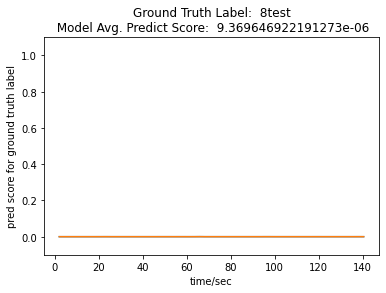

In [59]:
import matplotlib.pyplot as plt
import numpy as np


for tvn in clip_duration_dict:
    interval = clip_duration_dict[tvn][0]/list(y_test).count(tvn)
    x = np.arange(0, clip_duration_dict[tvn][0], interval) + interval
    y_idx = np.argmax(y_pred_test_prob[tvn], 1)
    y = y_pred_test_prob[tvn][:, 1]
    x = x[:len(y)]
    plt.plot(x, y)
    plt.ylim([-0.1, 1.1])
    plt.xlabel ('time/sec')
    plt.ylabel ('pred score for ground truth label')
    plt.title("Ground Truth Label:  " + tvn  + "\n Model Avg. Predict Score:  " + str(np.mean(y))) # str(real_prediction_dict[tvn]['score'])
    plt.savefig(opt.root_path + "/jiang/" + tvn, bbox_inches='tight')
    plt.close()

### Generate Json

In [60]:
import numpy as np


timeTrueLabel = {}
for tvn in clip_duration_dict:
    if tvn in y_pred_test_prob:
        interval = clip_duration_dict[tvn][0]/list(y_test).count(tvn)
        x = np.arange(0, clip_duration_dict[tvn][0], interval) + interval
        y_idx = np.argmax(y_pred_test_prob[tvn], 1)
        y = y_pred_test_prob[tvn][:, 1]
        x = x[:len(y)]  
        timeTrueLabel[tvn] = [[str(time), str(y[idx])] for idx, time in enumerate(x)]

In [61]:
with open(opt.root_path + '/jiang/timeLabel.json', 'w') as fp:
    json.dump(timeTrueLabel, fp)

In [62]:
with open(opt.root_path + '/jiang/timeLabel.json', 'r') as fp:
    qq = json.load(fp)